## Setup

In [30]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from src.tools import DataLoaderScratch, SGDScratch

## Load Data

In [31]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## Preprocessing

In [32]:
# Transform the training data
X_train = mnist_trainset.data.float() / 255.0
X_train = X_train.view(X_train.shape[0], -1)
y_train = mnist_trainset.targets

# Transform the test data
X_val = mnist_testset.data.float() / 255.0
X_val = X_val.view(X_val.shape[0], -1)
y_val = mnist_testset.targets

train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=256, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=256, shuffle=False)

## Logistic Regression From Scratch

### Single Batch from Scratch

In [33]:
num_samples = X_train.shape[0]
num_classes = y_train.unique().shape[0]
batch_size = 64

# Initialize W, it should be shape (num_features, num_classes) because it will 
# transform the input (num_examples, num_features) to the output (num_examples, num_classes)
W = torch.randn(size=(X_train.shape[1], num_classes), requires_grad=True)
# Initialize b, it should be shape (1, 1) because it will be a scalar we add to each class 
# prediction for each example
b = torch.zeros(num_classes, requires_grad=True)
                
# Define softmax, which maps scalars to probabilities
def softmax(X):
    X_exp = torch.exp(X)
    return X_exp / X_exp.sum(axis=1, keepdims=True)

# Define the log-loss 
def log_loss(y_pred, y):
    y_one_hot = nn.functional.one_hot(y)
    loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
    return loss

parameters = [W, b]
optimizer = SGDScratch(parameters, lr=0.1)

# Create a batch
X_batch = X_train[: batch_size]
y_batch = y_train[: batch_size]

In [36]:
# Zero gradients
optimizer.zero_grad()

# Forward pass (training)
O = X_batch @ W + b
y_pred = softmax(O)

# Calculate Loss
loss = log_loss(y_pred, y_batch)

# Backward pass (compute gradients)
loss.backward()

# Update parameters
optimizer.step()

### Define Training Loop and Model

In [51]:
class LogisticRegressionScratch(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.W = torch.randn(size=(in_features, num_classes), requires_grad=True)
        self.b = torch.zeros(num_classes, requires_grad=True)

    def softmax(self, X):
        X_exp = torch.exp(X)
        X_softmax = X_exp / X_exp.sum(axis=1, keepdims=True)
        return X_softmax

    def forward(self, X):
        O = X @ self.W + self.b
        y_pred = self.softmax(O)
        return y_pred

    def loss(self, y_pred, y):
        y_one_hot = nn.functional.one_hot(y, self.num_classes)
        loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
        return loss
    
    def parameters(self):
        return [self.W, self.b]

    def accuracy(self, y_pred, y):
        label_pred = torch.argmax(y_pred, axis=1)
        accuracy = torch.sum(label_pred == y) / y_pred.shape[0]
        return accuracy

    def fit(self, train_dataloader, val_dataloader, num_epochs, optimizer):
        train_losses, val_losses, val_accuracies = [], [], []

        for epoch in range(num_epochs):
            total_train_loss = 0
            for X_train_batch, y_train_batch in train_dataloader:
                # Zero gradients
                optimizer.zero_grad()

                # Forward pass (training)
                y_pred_train_batch = self.forward(X_train_batch)

                # Compute loss
                train_loss_batch = self.loss(y_pred_train_batch, y_train_batch)

                # Backward pass
                train_loss_batch.backward()
                total_train_loss += train_loss_batch.item()

                # Update parameters
                optimizer.step()

            # Store average train loss
            average_train_loss = total_train_loss / len(train_dataloader)
            train_losses.append(average_train_loss)

            # Forward pass (validation)
            with torch.no_grad():
                total_val_loss = 0
                total_val_accuracy = 0

                for X_val_batch, y_val_batch in val_dataloader:
                    # Calculate val loss metrics
                    y_pred_val_batch = self.forward(X_val_batch)
                    loss_val_batch = self.loss(y_pred_val_batch, y_val_batch)
                    accuracy_val_batch = self.accuracy(y_pred_val_batch, y_val_batch)

                    # Accumulate the total epoch metrics
                    total_val_loss += loss_val_batch.item()
                    total_val_accuracy += accuracy_val_batch.item()

            # Store average val metrics
            average_val_loss = total_val_loss / len(val_dataloader)
            average_val_accuracy = total_val_accuracy / len(val_dataloader)

            val_losses.append(average_val_loss)
            val_accuracies.append(average_val_accuracy)

            # Print loss every few epochs
            if epoch % 10 == 0:
                print(
                    f"Epoch {epoch+1}/{num_epochs}, Training Loss: {average_train_loss}, Validation Loss: {average_val_loss}"
                )

        # Plot the training and validation losses
        plt.plot(train_losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.plot(val_accuracies, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.show()

### Training the Model

Epoch 1/10, Training Loss: 4.43498244792857, Validation Loss: 2.110604517161846


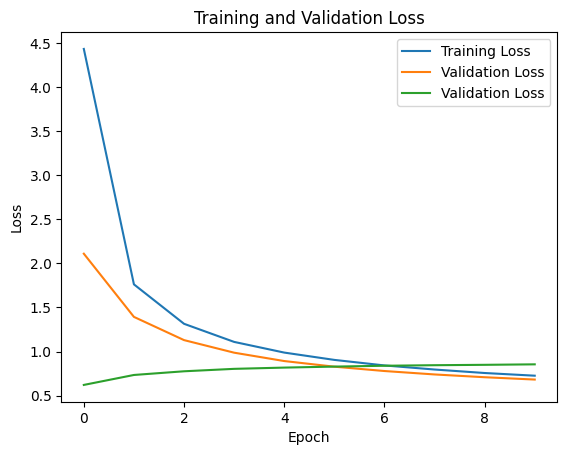

In [52]:
in_features = X_train.shape[1]
num_classes = y_train.unique().shape[0]
num_epochs = 10
learning_rate = 0.1

model = LogisticRegressionScratch(in_features=in_features, num_classes=num_classes)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
model.fit(train_dataloader, val_dataloader, num_epochs, optimizer)

## Concise Implementation of Logistic Regression

In [69]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define DataLoader
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the Linear Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.linear(x)
        out = self.softmax(out)
        return out

model = LogisticRegression(input_size=X_train.shape[1], num_classes=y_train.unique().shape[0])

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Train the Model
for epoch in range(10):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

In [72]:
loss

tensor(1.6314, grad_fn=<NllLossBackward0>)